<blockquote>
    <h1>Exercise 8.9</h1>
    <p>This problem involves the <code>OJ</code> data set which is part of the <code>ISLR</code> package.</p>
    <ol>
        <li>Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.</li>
        <li>Fit a tree to the training data, with $\mathrm{Purchase}$ as the response and the other variables as predictors. Use the <code>summary()</code> function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?</li>
        <li>Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.</li>
        <li>Create a plot of the tree, and interpret the results.</li>
        <li>Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?</li>
        <li>Apply the <code>cv.tree()</code> function to the training set in order to determine the optimal tree size.</li>
        <li>Produce a plot with tree size on the $x$-axis and cross-validated classification error rate on the $y$-axis.</li>
        <li>Which tree size corresponds to the lowest cross-validated classification error rate?</li>
        <li>Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.</li>
        <li>Compare the training error rates between the pruned and unpruned trees. Which is higher?</li>
        <li>Compare the test error rates between the pruned and unpruned trees. Which is higher?</li>
    </ol>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import interactive  # https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from sklearn.preprocessing import OneHotEncoder  # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("../../DataSets/OJ/OJ.csv")
df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [3]:
# Convert categorical independent data using one hot encoding:
# which takes a column with categorical data and 
# then splits the column into multiple columns. 
# The numbers are replaced by 1s and 0s, depending 
# on which column has what value. 
categorical_lst = ['STORE', 'SpecialCH', 'SpecialMM', 'Store7', 'StoreID']
columns = df.columns.tolist()
indices = [index for index, column in enumerate(columns) if column in categorical_lst]

onehotencoder = OneHotEncoder()
categorical_transformed = onehotencoder.fit_transform(df[categorical_lst]).toarray()
    
new_categorical_lst = []
for categorical_name, np_arr in zip(categorical_lst, onehotencoder.categories_):
    temp_lst = [f'{categorical_name} ({category})' for category in np_arr]
    new_categorical_lst.extend(temp_lst)
    
df_categorical_transformed = pd.DataFrame(categorical_transformed, columns=new_categorical_lst, dtype='int64')
for column in new_categorical_lst:
    df_categorical_transformed[column] = df_categorical_transformed[column].astype('category')

df_transformed = pd.concat([df.drop(categorical_lst, 1), df_categorical_transformed], axis=1)
df_transformed.head()

,Purchase,WeekofPurchase,PriceCH,PriceMM,DiscCH,DiscMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,...,SpecialCH (1),SpecialMM (0),SpecialMM (1),Store7 (No),Store7 (Yes),StoreID (1),StoreID (2),StoreID (3),StoreID (4),StoreID (7)
0,CH,237,1.75,1.99,0.00,0.0,0.500000,1.99,1.75,0.24,...,0,1,0,1,0,1,0,0,0,0
1,CH,239,1.75,1.99,0.00,0.3,0.600000,1.69,1.75,-0.06,...,0,0,1,1,0,1,0,0,0,0
2,CH,245,1.86,2.09,0.17,0.0,0.680000,2.09,1.69,0.40,...,0,1,0,1,0,1,0,0,0,0
3,MM,227,1.69,1.69,0.00,0.0,0.400000,1.69,1.69,0.00,...,0,1,0,1,0,1,0,0,0,0
4,CH,228,1.69,1.69,0.00,0.0,0.956535,1.69,1.69,0.00,...,0,1,0,0,1,0,0,0,0,1


In [4]:
# https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
# Interactive Visualization of Decision Trees with Jupyter Widgets

def plot_tree(splitter, criterion, max_depth, min_samples_split, min_samples_leaf=0.2):
    tree_class = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree_class.fit(df_transformed.drop('Purchase', 1), df_transformed[['Purchase']])
    
    graph = Source(export_graphviz(
        tree_class,
        out_file=None,
        feature_names=df_transformed.drop('Purchase', 1).columns.tolist(),
        class_names=tree_class.classes_,
        rounded=True,
        filled=True
    ))
   
    display(SVG(graph.pipe(format='svg')))
    return tree_class

inter = interactive(
    plot_tree,
    criterion=['gini', 'entropy'],
    splitter=['best', 'random'],
    max_depth=[1, 2, 3, 4],
    min_samples_split=(0.1, 1),
    min_samples_leaf=(0.1, 0.5)
)

display(inter)

interactive(children=(Dropdown(description='splitter', options=('best', 'random'), value='best'), Dropdown(des…

<h3>Exercise 8.9.1</h3>
<blockquote>
    <i>Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.</i>
</blockquote>

In [5]:
df_y = df_transformed[['Purchase']]
df_x = df_transformed.drop('Purchase', 1)
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, 
    df_y, 
    train_size=800, 
    random_state=42
)

<h3>Exercise 8.9.2</h3>
<blockquote>
    <i>Fit a tree to the training data, with $\mathrm{Purchase}$ as the response and the other variables as predictors. Use the <code>summary()</code> function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?</i>
</blockquote>

In [6]:
tree_class = DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    max_depth=2,
    random_state=42
)
_ = tree_class.fit(df_x_train, df_y_train)

y_pred_train = tree_class.predict(df_x_train)
cm = confusion_matrix(y_true=df_y_train, y_pred=y_pred_train)
index = pd.MultiIndex.from_tuples([('actual', 'CH'), ('actual', 'MM')])
columns = pd.MultiIndex.from_tuples([('predicted', 'CH'), ('predicted', 'MM')])
cm = pd.DataFrame(cm, columns=columns, index=index)
cm

predicted     
                 CH   MM
actual CH       391  103
       MM        55  251

In [7]:
print(classification_report(df_y_train, y_pred_train))

              precision    recall  f1-score   support

          CH       0.88      0.79      0.83       494
          MM       0.71      0.82      0.76       306

    accuracy                           0.80       800
   macro avg       0.79      0.81      0.80       800
weighted avg       0.81      0.80      0.80       800



<h3>Exercise 8.9.3</h3>
<blockquote>
    <i>Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.</i>
</blockquote>

<h3>Exercise 8.9.4</h3>
<blockquote>
    <i>Create a plot of the tree, and interpret the results.</i>
</blockquote>

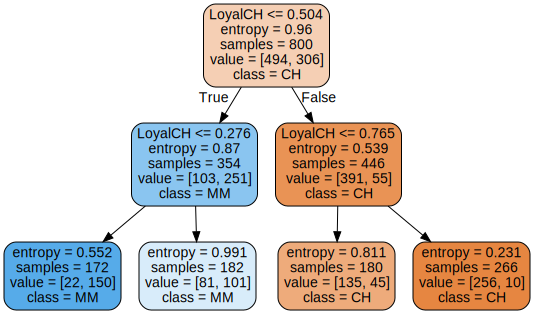

In [8]:
transformed_columns_lst = df_x.columns.tolist()
graph = Source(export_graphviz(
    tree_class, 
    out_file=None,
    feature_names=transformed_columns_lst,
    class_names=tree_class.classes_,
    rounded=True,
    filled=True
))

display(SVG(graph.pipe(format='svg')))

<h3>Exercise 8.9.5</h3>
<blockquote>
    <i>Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?</i>
</blockquote>

In [9]:
y_pred_test = tree_class.predict(df_x_test)
cm = confusion_matrix(y_true=df_y_test, y_pred=y_pred_test)
index = pd.MultiIndex.from_tuples([('actual', 'CH'), ('actual', 'MM')])
columns = pd.MultiIndex.from_tuples([('predicted', 'CH'), ('predicted', 'MM')])
cm = pd.DataFrame(cm, columns=columns, index=index)
cm

predicted    
                 CH  MM
actual CH       129  30
       MM        26  85

<h3>Exercise 8.9.6</h3>
<blockquote>
    <i>Apply the <code>cv.tree()</code> function to the training set in order to determine the optimal tree size.</i>
</blockquote>

In [10]:
parameters = {'max_depth': range(3,20)}
tree_class_cv = GridSearchCV(DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    random_state=42
), parameters, n_jobs=-1)
_ = tree_class_cv.fit(df_x, df_y)
tree_model = tree_class_cv.best_estimator_
tree_class_cv.best_params_

{'max_depth': 4}

<h3>Exercise 8.9.7</h3>
<blockquote>
    <i>Produce a plot with tree size on the $x$-axis and cross-validated classification error rate on the $y$-axis.</i>
</blockquote>

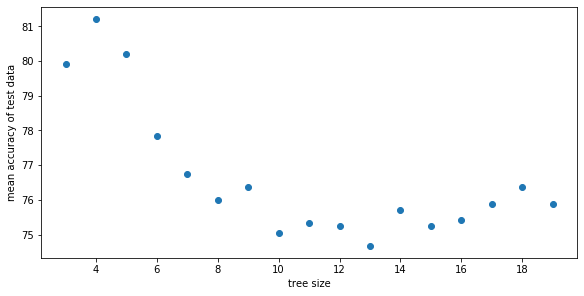

In [11]:
tree_size = [list(params_dct.values())[0] 
             for params_dct in tree_class_cv.cv_results_['params']]
accuracy = 100*tree_class_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax.scatter(tree_size, accuracy)
_ = ax.set_xlabel('tree size')
_ = ax.set_ylabel('mean accuracy of test data')

<h3>Exercise 8.9.8</h3>
<blockquote>
    <i>Which tree size corresponds to the lowest cross-validated classification error rate?</i>
</blockquote>

In [12]:
tree_class_cv.best_params_

{'max_depth': 4}

<h3>Exercise 8.9.9</h3>
<blockquote>
    <i>Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.</i>
</blockquote>

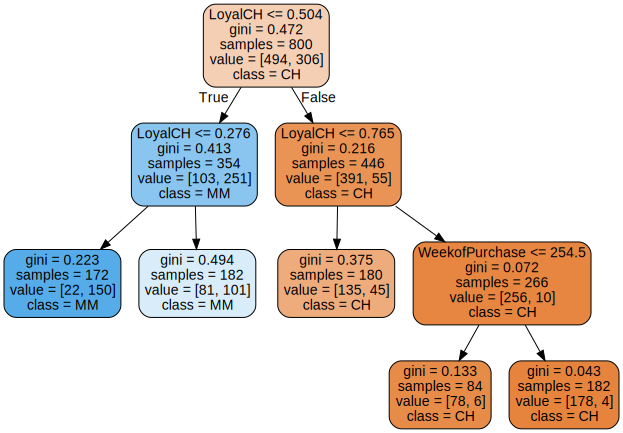

In [13]:
# pre-pruning
tree_class_pruned = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=3,
    min_samples_split=0.3,
    min_samples_leaf=0.1,
    random_state=42
)
_ = tree_class_pruned.fit(df_x_train, df_y_train)

graph = Source(export_graphviz(
    tree_class_pruned, 
    out_file=None,
    feature_names=transformed_columns_lst,
    class_names=tree_class.classes_,
    rounded=True,
    filled=True
))

display(SVG(graph.pipe(format='svg')))

<h3>Exercise 8.9.10</h3>
<blockquote>
    <i>Compare the training error rates between the pruned and unpruned trees. Which is higher?
</i>
</blockquote>

In [14]:
print(f'pruned (train data): {100*tree_class_pruned.score(df_x_train, df_y_train):.2f} %')
print(f'unpruned (train data): {100*tree_class_cv.score(df_x_train, df_y_train):.2f} %')

pruned (train data): 80.25 %
unpruned (train data): 84.50 %


<h3>Exercise 8.9.11</h3>
<blockquote>
    <i>Compare the test error rates between the pruned and unpruned trees. Which is higher?</i>
</blockquote>

In [15]:
print(f'pruned (test data): {100*tree_class_pruned.score(df_x_test, df_y_test):.2f} %')
print(f'unpruned (test data): {100*tree_class_cv.score(df_x_test, df_y_test):.2f} %')

pruned (test data): 79.26 %
unpruned (test data): 82.59 %
